In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from IPython.display import display
import glob
from tqdm import tqdm
import os

In [18]:
precovid_folder = "/Users/sarahyuhan/BostonBusEquity/2015-2017-tables"
#all the export files in 2015-2017
file_paths = glob.glob(os.path.join(precovid_folder, '*export.xlsx'))

df_list = [pd.read_excel(file) for file in file_paths]
df_pre = pd.concat(df_list, ignore_index=True)

# Show the combined DataFrame
df_pre.head()

postcovid = "/Users/sarahyuhan/BostonBusEquity/2023.csv"
df_post = pd.read_csv(postcovid)

df_post = df_post[df_post['service_mode'] == 'Bus']

In [3]:
df_pre.head(),df_post.head()

(  Mode  Trip purpose: Home-based work  Trip purpose: Home-based school  \
 0  Bus                         230731                            27070   
 
    Trip purpose: Home-based social activity  Trip purpose: Home-based other  \
 0                                     13451                           40299   
 
    Trip purpose: Non-home-based  Count: Trip purpose  \
 0                         19531                33584   
 
    Trip frequency: 6-7 days a week  Trip frequency: 5 days a week  \
 0                            45942                         194400   
 
    Trip frequency: 3-4 days a week  ...  Gender: Woman  Gender: Other  \
 0                            51109  ...         224195            567   
 
    Gender: Prefer not to say  Count: Gender  \
 0                       7263          35858   
 
    Ability to understand English: Always  \
 0                                 336719   
 
    Ability to understand English: Often  \
 0                                  9947   


In [19]:
df_pre_numeric = df_pre.drop(columns=["Mode"], errors="ignore").apply(pd.to_numeric, errors="coerce")

# Step 1: Create a mapping of categories from df_post
df_post.columns = df_post.columns.str.strip().str.lower()
df_post['full_category'] = df_post['measure_group'] + ": " + df_post['category']

# Step 2: Extract unique category names
category_mapping = df_post[['category', 'full_category']].drop_duplicates().set_index('category').to_dict()['full_category']

# Step 3: Rename df_pre columns using this mapping
df_post.rename(columns=lambda x: x.strip(), inplace=True)

df_post.rename(columns={
    'weighted_percent': 'percentage'
}, inplace=True)


df_pre.columns, df_post.columns


(Index(['Route', 'Trip Purpose: Home-based work',
        'Trip Purpose: Home-based school',
        'Trip Purpose: Home-based social activity',
        'Trip Purpose: Home-based other', 'Trip Purpose: Non-home-based',
        'Trip Frequency: 6-7 days a week', 'Trip Frequency: 5 days a week',
        'Trip Frequency: 3-4 days a week', 'Trip Frequency: 1-2 days a week',
        'Trip Frequency: 1-3 days a month',
        'Trip Frequency: Less than once a month', 'Income: Less than $14,500',
        'Income: $14,500 to $28,999', 'Income: $29,000 to $43,499',
        'Income: $43,500 to $57,999', 'Income: $58,000 to $75,999',
        'Income: $76,000 to $108,499', 'Income: $108,500 to $151,999',
        'Income: $152,000 or more', 'Income: Prefer not to say',
        'Low-income: Yes', 'Low-income: No', 'Age: Under 18', 'Age: 18 to 21',
        'Age: 22 to 34', 'Age: 35 to 44', 'Age: 45 to 64', 'Age: 65 or over',
        'Gender: Man', 'Gender: Woman', 'Gender: Other',
        'Gender: P

In [22]:
print(df_pre_numeric.columns.tolist())


['Route', 'Trip Purpose: Home-based work', 'Trip Purpose: Home-based school', 'Trip Purpose: Home-based social activity', 'Trip Purpose: Home-based other', 'Trip Purpose: Non-home-based', 'Trip Frequency: 6-7 days a week', 'Trip Frequency: 5 days a week', 'Trip Frequency: 3-4 days a week', 'Trip Frequency: 1-2 days a week', 'Trip Frequency: 1-3 days a month', 'Trip Frequency: Less than once a month', 'Income: Less than $14,500', 'Income: $14,500 to $28,999', 'Income: $29,000 to $43,499', 'Income: $43,500 to $57,999', 'Income: $58,000 to $75,999', 'Income: $76,000 to $108,499', 'Income: $108,500 to $151,999', 'Income: $152,000 or more', 'Income: Prefer not to say', 'Low-income: Yes', 'Low-income: No', 'Age: Under 18', 'Age: 18 to 21', 'Age: 22 to 34', 'Age: 35 to 44', 'Age: 45 to 64', 'Age: 65 or over', 'Gender: Man', 'Gender: Woman', 'Gender: Other', 'Gender: Prefer not to say', 'English Ability: Always', 'English Ability: Often', 'English Ability: Sometimes', 'English Ability: Never',

In [20]:
print(df_post.isnull().sum())
df_post = df_post.dropna()
df_pre = df_pre.dropna()

aggregation_level    0
service_mode         0
reporting_group      0
measure_group        0
measure              0
category             1
percentage           0
objectid             0
full_category        1
dtype: int64


In [16]:
print("Columns in df_post:", df_post.columns)


Columns in df_post: Index(['aggregation_level', 'service_mode', 'reporting_group', 'measure_group',
       'measure', 'category', 'percentage', 'objectid', 'full_category'],
      dtype='object')


In [25]:
#COMPARING PERCENTAGES in number of people from each category taking the bus pre covid and post covid
# Ensure column names in df_post are standardized
df_post.columns = df_post.columns.str.strip().str.lower()
df_post["percentage"] = df_post["percentage"] * 100

df_post['full_category'] = df_post['measure'] + ": " + df_post['category']

# Extract unique category names from df_post for renaming df_pre
category_mapping = df_post[['category', 'full_category']].drop_duplicates().set_index('category').to_dict()['full_category']

# Drop non-numeric columns from df_pre and convert to numeric
df_pre_numeric = df_pre.drop(columns=["Mode"], errors="ignore").apply(pd.to_numeric, errors="coerce")

category_totals = df_pre_numeric.groupby(lambda x: x.split(":")[0], axis=1).sum()
pre_percentages = df_pre_numeric.apply(lambda x: (x / category_totals[x.name.split(":")[0]]) * 100 if x.name.split(":")[0] in category_totals else x, axis=0)
pre_percentages = pre_percentages.rename(columns=category_mapping)

# Convert to DataFrame for merging
pre_percentages = pre_percentages.T
pre_percentages = pre_percentages.reset_index()
pre_percentages = pre_percentages.rename(columns={pre_percentages.columns[0]: 'pre_covid_percent'})
pre_percentages['full_category'] = pre_percentages.index
pre_percentages = pre_percentages.reset_index(drop=True)


# Merge with df_post based on full_category
df_comparison = pd.merge(pre_percentages, df_post[['measure_group', 'full_category', 'percentage']], 
                         on="full_category", how="inner")

# create Separate Tables for Each Measure**
grouped_tables = {measure: data for measure, data in df_comparison.groupby("measure_group")}

# display
for measure, table in grouped_tables.items():
    print(f"\nComparison Table for {measure}:")
    display(table)

/var/folders/gh/8gsn76px7tn2s_cff89q_8ww0000gn/T/ipykernel_2251/2944411471.py:14: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  category_totals = df_pre_numeric.groupby(lambda x: x.split(":")[0], axis=1).sum()


ValueError: You are trying to merge on int64 and object columns for key 'full_category'. If you wish to proceed you should use pd.concat

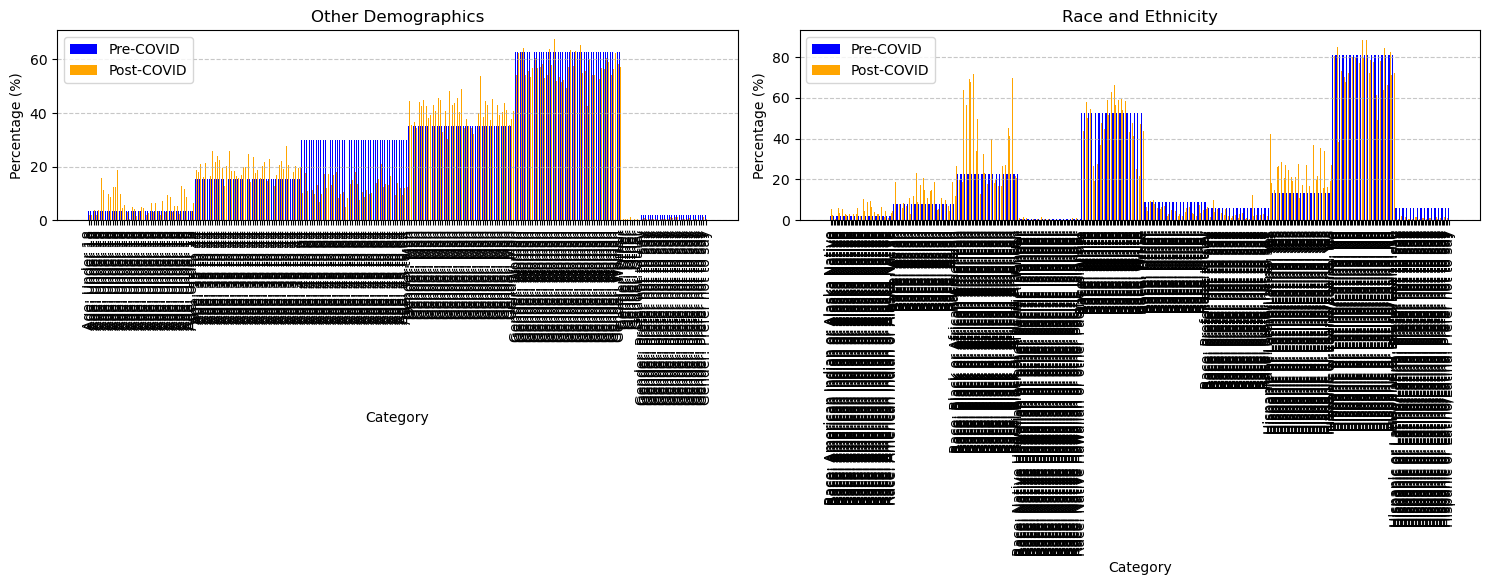

TypeError: DataFrame.pivot() takes 1 positional argument but 4 were given

In [18]:
plt.figure(figsize=(15, 8))
num_plots = len(grouped_tables)
colors = ['blue', 'orange']

for idx, (measure, table) in enumerate(grouped_tables.items(), 1):
    plt.subplot((num_plots // 2) + 1, 2, idx)  # Arrange subplots
    x = np.arange(len(table["full_category"]))
    
    plt.bar(x - 0.2, table["pre_covid_percent"], width=0.4, label="Pre-COVID", color=colors[0])
    plt.bar(x + 0.2, table["percentage"], width=0.4, label="Post-COVID", color=colors[1])

    plt.xticks(x, table["full_category"], rotation=90)
    plt.ylabel("Percentage (%)")
    plt.xlabel("Category")
    plt.title(measure)
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

# **Step 4: Heatmap for Overall Percentage Differences**
df_comparison["difference"] = df_comparison["pre_covid_percent"] - df_comparison["percentage"]
pivot_table = df_comparison.pivot("full_category", "measure_group", "difference")

plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Pre vs Post COVID Percentage Differences by Measure")
plt.ylabel("Category")
plt.xlabel("Measure Group")
plt.show()

In [ ]:
#now for identifying characteristics associated with lateness
# identify the routes that are later than usual and see which categories have higher percentages associated with those routes

# using simon's code computing lateness

# Step 1: Load CSV Files
file_pattern = "/Users/sarahyuhan/BostonBusEquity/MBTA-Bus-Arrival-Departure-Times_2023-*.csv"
file_paths = sorted(glob.glob(file_pattern))

# Step 2: Define Variables
chunksize = 500000
route_lateness = []
route_counts = []
route_ids = []

outlier_threshold = 3600  # Outlier threshold: 1 hour (3600 seconds)

# Ensure we have files
if not file_paths:
    print("No CSV files found. Check the file path!")

# Step 3: Process Each File in Chunks
for file_path in file_paths:
    print(f"Processing: {file_path}", flush=True)
    
    for chunk in tqdm(pd.read_csv(file_path, chunksize=chunksize), desc=f"Processing {file_path}"):
        # Convert time columns and remove invalid entries
        chunk["service_date"] = pd.to_datetime(chunk["service_date"], errors="coerce")
        chunk["scheduled"] = pd.to_datetime(chunk["scheduled"], errors="coerce")
        chunk["actual"] = pd.to_datetime(chunk["actual"], errors="coerce")
        chunk.dropna(subset=["service_date", "scheduled", "actual"], inplace=True)

        # Ensure proper timezone handling (remove timezone info if necessary)
        chunk["service_date"] = chunk["service_date"].dt.tz_localize(None)
        chunk["scheduled"] = chunk["scheduled"].dt.tz_localize(None)
        chunk["actual"] = chunk["actual"].dt.tz_localize(None)

        # Use reference time for accurate lateness calculation
        reference_time = pd.Timestamp("1900-01-01 00:00:00").tz_localize(None)
        chunk["scheduled_seconds"] = (chunk["scheduled"] - reference_time).dt.total_seconds()
        chunk["actual_seconds"] = (chunk["actual"] - reference_time).dt.total_seconds()

        # Adjust timestamps using service_date
        chunk["scheduled"] = chunk["service_date"] + pd.to_timedelta(chunk["scheduled_seconds"], unit="s")
        chunk["actual"] = chunk["service_date"] + pd.to_timedelta(chunk["actual_seconds"], unit="s")

        # Compute lateness
        chunk["lateness"] = (chunk["actual"] - chunk["scheduled"]).dt.total_seconds()

        # **Filter Outliers (Keep values within -1 hour to +1 hour)**
        chunk = chunk[chunk["lateness"].abs() <= outlier_threshold]

        # Group by route_id (sum of lateness, count of trips)
        grouped = chunk.groupby(["route_id"])["lateness"].agg(["sum", "count"]).reset_index()

        # Store results
        if not grouped.empty:
            route_lateness.append(grouped["sum"].values)
            route_counts.append(grouped["count"].values)
            route_ids.append(grouped["route_id"].values)

# Debugging print to check data collected
print(f"Route lateness collected: {len(route_lateness)}")
print(f"Route counts collected: {len(route_counts)}")
print(f"Route IDs collected: {len(route_ids)}")

# Step 4: Aggregate Total Lateness and Compute Average
total_lateness = sum(map(sum, route_lateness)) if route_lateness else 0
total_counts = sum(map(sum, route_counts)) if route_counts else 0
average_lateness = total_lateness / total_counts if total_counts > 0 else 0  # Avoid division by zero

# Step 5: Create DataFrame of Lateness per Route
lateness_df = pd.DataFrame({
    "route_id": np.concatenate(route_ids) if route_ids else [],
    "total_lateness": np.concatenate(route_lateness) if route_lateness else [],
    "trip_count": np.concatenate(route_counts) if route_counts else []
})

# Compute average lateness per route
if not lateness_df.empty:
    lateness_df["average_lateness"] = lateness_df["total_lateness"] / lateness_df["trip_count"]

# we want to use the routes with lateness that is above average in order answer the question of what demographic of people are affected most by lateness
above_avg_routes = lateness_df[lateness_df["average_lateness"] > average_lateness] if not lateness_df.empty else pd.DataFrame()

# Display results
print(f"Citywide Average Lateness: {average_lateness:.2f} seconds")
print("\nRoutes with above-average lateness:")
print(above_avg_routes)


Processing: /Users/sarahyuhan/BostonBusEquity/MBTA-Bus-Arrival-Departure-Times_2023-01.csv


Processing /Users/sarahyuhan/BostonBusEquity/MBTA-Bus-Arrival-Departure-Times_2023-01.csv: 5it [00:14,  2.85s/it]

Processing: /Users/sarahyuhan/BostonBusEquity/MBTA-Bus-Arrival-Departure-Times_2023-02.csv



Processing /Users/sarahyuhan/BostonBusEquity/MBTA-Bus-Arrival-Departure-Times_2023-02.csv: 5it [00:12,  2.44s/it]

Processing: /Users/sarahyuhan/BostonBusEquity/MBTA-Bus-Arrival-Departure-Times_2023-03.csv



Processing /Users/sarahyuhan/BostonBusEquity/MBTA-Bus-Arrival-Departure-Times_2023-03.csv: 5it [00:16,  3.20s/it]

Processing: /Users/sarahyuhan/BostonBusEquity/MBTA-Bus-Arrival-Departure-Times_2023-04.csv



Processing /Users/sarahyuhan/BostonBusEquity/MBTA-Bus-Arrival-Departure-Times_2023-04.csv: 5it [00:13,  2.68s/it]

Processing: /Users/sarahyuhan/BostonBusEquity/MBTA-Bus-Arrival-Departure-Times_2023-05.csv



Processing /Users/sarahyuhan/BostonBusEquity/MBTA-Bus-Arrival-Departure-Times_2023-05.csv: 5it [00:13,  2.79s/it]

Processing: /Users/sarahyuhan/BostonBusEquity/MBTA-Bus-Arrival-Departure-Times_2023-06.csv



Processing /Users/sarahyuhan/BostonBusEquity/MBTA-Bus-Arrival-Departure-Times_2023-06.csv: 5it [00:13,  2.70s/it]

Processing: /Users/sarahyuhan/BostonBusEquity/MBTA-Bus-Arrival-Departure-Times_2023-07.csv



Processing /Users/sarahyuhan/BostonBusEquity/MBTA-Bus-Arrival-Departure-Times_2023-07.csv: 5it [00:13,  2.72s/it]

Processing: /Users/sarahyuhan/BostonBusEquity/MBTA-Bus-Arrival-Departure-Times_2023-08.csv



Processing /Users/sarahyuhan/BostonBusEquity/MBTA-Bus-Arrival-Departure-Times_2023-08.csv: 5it [00:12,  2.57s/it]

Processing: /Users/sarahyuhan/BostonBusEquity/MBTA-Bus-Arrival-Departure-Times_2023-09.csv



Processing /Users/sarahyuhan/BostonBusEquity/MBTA-Bus-Arrival-Departure-Times_2023-09.csv: 5it [00:12,  2.54s/it]

Processing: /Users/sarahyuhan/BostonBusEquity/MBTA-Bus-Arrival-Departure-Times_2023-10.csv



Processing /Users/sarahyuhan/BostonBusEquity/MBTA-Bus-Arrival-Departure-Times_2023-10.csv: 5it [00:13,  2.71s/it]

Processing: /Users/sarahyuhan/BostonBusEquity/MBTA-Bus-Arrival-Departure-Times_2023-11.csv



Processing /Users/sarahyuhan/BostonBusEquity/MBTA-Bus-Arrival-Departure-Times_2023-11.csv: 5it [00:12,  2.58s/it]

Processing: /Users/sarahyuhan/BostonBusEquity/MBTA-Bus-Arrival-Departure-Times_2023-12.csv



Processing /Users/sarahyuhan/BostonBusEquity/MBTA-Bus-Arrival-Departure-Times_2023-12.csv: 5it [00:14,  2.82s/it]

Route lateness collected: 60
Route counts collected: 60
Route IDs collected: 60
Citywide Average Lateness: 243.43 seconds

Routes with above-average lateness:
     route_id  total_lateness  trip_count  average_lateness
4          09       1438019.0        5894        243.980149
13         11       1284310.0        4230        303.619385
21        120        663215.0        2411        275.078805
22        121        105137.0         344        305.630814
32         18         97609.0         376        259.598404
...       ...             ...         ...               ...
8969       29        170201.0         479        355.325678
8970       30        189830.0         724        262.196133
8975      34E        754550.0        2776        271.811960
8994      435        141351.0         577        244.975737
9052       97        155402.0         490        317.146939

[3583 rows x 4 columns]


In [9]:
#since there is no arrival-departure data for the years 2015-2017 we use 2018 data instead
# using simon's code computing lateness now for 2018 arrivals and departures
file_pattern2 = "/Users/sarahyuhan/BostonBusEquity/MBTA-Bus-Arrival-Departure-*-2018.csv"
file_paths2 = sorted(glob.glob(file_pattern2))

chunksize = 500000
route_lateness2 = []
route_counts2 = []
route_ids2 = []

outlier_threshold = 3600  # Outlier threshold: 1 hour (3600 seconds)

# Ensure we have files
if not file_paths2:
    print("No CSV files found. Check the file path!")

for file_path in file_paths2:
    print(f"Processing: {file_path}", flush=True)
    
    for chunk in tqdm(pd.read_csv(file_path, chunksize=chunksize), desc=f"Processing {file_path}"):
        # Convert time columns and remove invalid entries
        chunk["service_date"] = pd.to_datetime(chunk["service_date"], errors="coerce")
        chunk["scheduled"] = pd.to_datetime(chunk["scheduled"], errors="coerce")
        chunk["actual"] = pd.to_datetime(chunk["actual"], errors="coerce")
        chunk.dropna(subset=["service_date", "scheduled", "actual"], inplace=True)

        # Ensure proper timezone handling (remove timezone info if necessary)
        chunk["service_date"] = chunk["service_date"].dt.tz_localize(None)
        chunk["scheduled"] = chunk["scheduled"].dt.tz_localize(None)
        chunk["actual"] = chunk["actual"].dt.tz_localize(None)

        # Use reference time for accurate lateness calculation
        reference_time = pd.Timestamp("1900-01-01 00:00:00").tz_localize(None)
        chunk["scheduled_seconds"] = (chunk["scheduled"] - reference_time).dt.total_seconds()
        chunk["actual_seconds"] = (chunk["actual"] - reference_time).dt.total_seconds()

        # Adjust timestamps using service_date
        chunk["scheduled"] = chunk["service_date"] + pd.to_timedelta(chunk["scheduled_seconds"], unit="s")
        chunk["actual"] = chunk["service_date"] + pd.to_timedelta(chunk["actual_seconds"], unit="s")

        # Compute lateness
        chunk["lateness"] = (chunk["actual"] - chunk["scheduled"]).dt.total_seconds()

        # **Filter Outliers (Keep values within -1 hour to +1 hour)**
        chunk = chunk[chunk["lateness"].abs() <= outlier_threshold]

        # Group by route_id (sum of lateness, count of trips)
        grouped = chunk.groupby(["route_id"])["lateness"].agg(["sum", "count"]).reset_index()

        # Store results
        if not grouped.empty:
            route_lateness2.append(grouped["sum"].values)
            route_counts2.append(grouped["count"].values)
            route_ids2.append(grouped["route_id"].values)

# Debugging print to check data collected
print(f"Route lateness collected: {len(route_lateness2)}")
print(f"Route counts collected: {len(route_counts2)}")
print(f"Route IDs collected: {len(route_ids2)}")

# Step 4: Aggregate Total Lateness and Compute Average
total_lateness2 = sum(map(sum, route_lateness2)) if route_lateness2 else 0
total_counts2 = sum(map(sum, route_counts2)) if route_counts2 else 0
average_lateness2 = total_lateness2 / total_counts2 if total_counts2 > 0 else 0  # Avoid division by zero

# Step 5: Create DataFrame of Lateness per Route
lateness_df2 = pd.DataFrame({
    "route_id": np.concatenate(route_ids2) if route_ids2 else [],
    "total_lateness": np.concatenate(route_lateness2) if route_lateness2 else [],
    "trip_count": np.concatenate(route_counts2) if route_counts2 else []
})

# Compute average lateness per route
if not lateness_df2.empty:
    lateness_df2["average_lateness"] = lateness_df2["total_lateness"] / lateness_df2["trip_count"]

# we want to use the routes with lateness that is above average in order answer the question of what demographic of people are affected most by lateness
above_avg_routes_2018 = lateness_df2[lateness_df2["average_lateness"] > average_lateness2] if not lateness_df2.empty else pd.DataFrame()

# Display results
print(f"Citywide Average Lateness: {average_lateness2:.2f} seconds")
print("\nRoutes with above-average lateness:")
print(above_avg_routes_2018)


Processing: /Users/sarahyuhan/BostonBusEquity/MBTA-Bus-Arrival-Departure-Aug-Sept-2018.csv


Processing /Users/sarahyuhan/BostonBusEquity/MBTA-Bus-Arrival-Departure-Aug-Sept-2018.csv: 11it [00:37,  3.40s/it]

Processing: /Users/sarahyuhan/BostonBusEquity/MBTA-Bus-Arrival-Departure-Oct-Dec-2018.csv



Processing /Users/sarahyuhan/BostonBusEquity/MBTA-Bus-Arrival-Departure-Oct-Dec-2018.csv: 16it [00:48,  3.01s/it]

Route lateness collected: 27
Route counts collected: 27
Route IDs collected: 27
Citywide Average Lateness: 249.47 seconds

Routes with above-average lateness:
     route_id  total_lateness  trip_count  average_lateness
0          01       5233144.0       11810        443.111262
4          08       1137104.0        4410        257.846712
8         101       1296259.0        4063        319.039872
9         104        989244.0        2687        368.159285
10        105        267470.0         834        320.707434
...       ...             ...         ...               ...
4523      114         38620.0         132        292.575758
4527      120        433151.0        1290        335.775969
4543      192         19402.0          48        404.208333
4544      193         19791.0          46        430.239130
4564      236        210803.0         759        277.737813

[2425 rows x 4 columns]


In [23]:
postcovid = "/Users/sarahyuhan/BostonBusEquity/2023.csv"
df_post = pd.read_csv(postcovid)

# Filter only bus routes
df_post = df_post[df_post['service_mode'] == 'Bus']

# Convert route_id to match post-COVID dataset format
above_avg_routes = above_avg_routes.copy()  # Ensure it's a copy
above_avg_routes["route_id"] = above_avg_routes["route_id"].astype(str)

df_post["reporting_group"] = df_post["reporting_group"].astype(str)

# Merge post-COVID data with routes that had above-average lateness
df_analysis = df_post[df_post["reporting_group"].isin(above_avg_routes["route_id"])]

In [24]:
print("\nRoutes with Higher Than Average Lateness:")
display(above_avg_routes) 


Routes with Higher Than Average Lateness:


,route_id,total_lateness,trip_count,average_lateness
4,09,1438019.0,5894,243.980149
13,11,1284310.0,4230,303.619385
21,120,663215.0,2411,275.078805
22,121,105137.0,344,305.630814
32,18,97609.0,376,259.598404
...,...,...,...,...
8969,29,170201.0,479,355.325678
8970,30,189830.0,724,262.196133
8975,34E,754550.0,2776,271.811960
8994,435,141351.0,577,244.975737


In [25]:
# Aggregate percentage data for routes with high lateness
category_analysis = df_analysis.groupby(["measure_group", "category"])["weighted_percent"].mean().reset_index()

# Sort to find the highest categories
category_analysis = category_analysis.sort_values(by="weighted_percent", ascending=False)

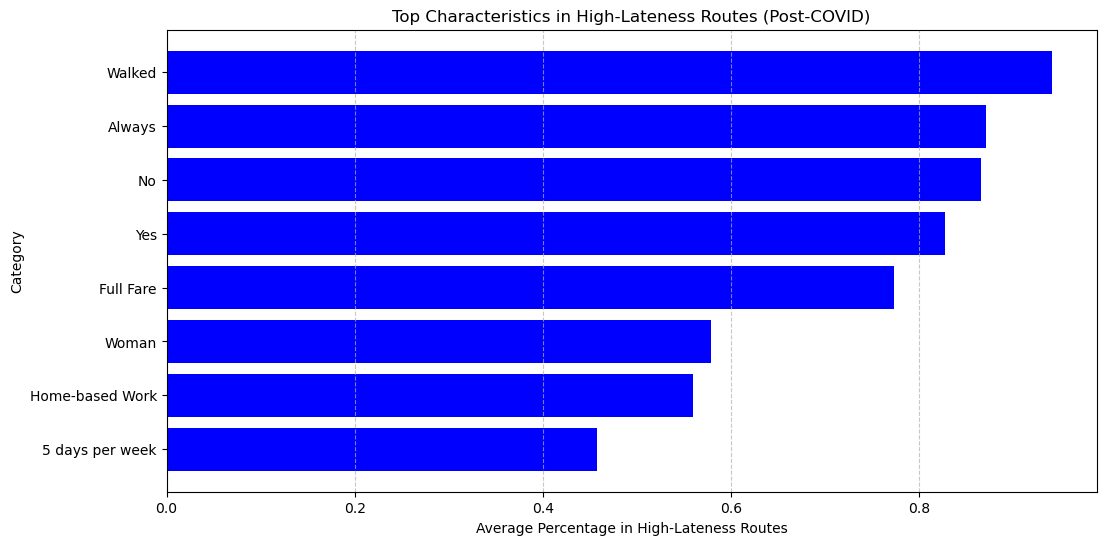

In [44]:
# Select top 10 characteristics
df_plot = category_analysis.head(10)

# Plot the categories
plt.figure(figsize=(12, 6))
plt.barh(df_plot["category"], df_plot["weighted_percent"], color="blue")

# Formatting
plt.xlabel("Average Percentage in High-Lateness Routes")
plt.ylabel("Category")
plt.title("Top Characteristics in High-Lateness Routes (Post-COVID)")
plt.gca().invert_yaxis()  # Highest values at the top
plt.grid(axis="x", linestyle="--", alpha=0.7)

# Show plot
plt.show()

In [36]:
df_post["full_category"] = df_post["measure"] + ": " + df_post["category"]
df_post["percentage"] = df_post["percentage"] * 100

# NOW filter using the updated df_post
df_analysis = df_post[df_post["reporting_group"].isin(above_avg_routes["route_id"])]


In [38]:
# Pivot to get categories as features
pivot_df = df_analysis.pivot_table(index='reporting_group', 
                                    columns='full_category', 
                                    values='percentage', 
                                    aggfunc='mean').fillna(0)

# Optional: merge in lateness
pivot_df = pivot_df.merge(lateness_df[["route_id", "average_lateness"]], 
                          left_index=True, right_on="route_id", how="left")
pivot_df = pivot_df.drop(columns="route_id")

In [39]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_features = scaler.fit_transform(pivot_df)

#normalizing the features
from sklearn.cluster import KMeans

#kmeans
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(scaled_features)

pivot_df["cluster"] = clusters

,Ability to Understand English: Always,Ability to Understand English: Never,Ability to Understand English: Often,Ability to Understand English: Prefer not to say,Ability to Understand English: Sometimes,"Access to First MBTA Service: Bike, Scooter or Other Micromobility",Access to First MBTA Service: Carpooled or Dropped off by Personal Vehicle,Access to First MBTA Service: Drove Alone,Access to First MBTA Service: Private Shuttle or Other Transit,Access to First MBTA Service: Taxi or Rideshare Company,...,Trip Purpose: Home-based Social Activity,Trip Purpose: Home-based Work,Trip Purpose: Non-home Based,Usable Cars: 0,Usable Cars: 1,Usable Cars: 2,Usable Cars: 3 or more,Used Alternative Mode: No,Used Alternative Mode: Yes,average_lateness
cluster,,,,,,,,,,,,,,,,,,,,,
0,831926.349500,15941.230125,70306.270125,3218.934750,78607.215375,12269.524375,19299.728250,2819.911375,14818.078875,12830.73825,...,73923.260125,517304.759750,80578.268500,438671.547250,388127.213125,144757.338750,28443.900875,869587.045125,130412.954875,241.591969
1,900438.805111,8601.381444,41732.801778,2663.608556,46563.403000,9830.878333,18241.216556,5114.640333,8530.828000,8698.84000,...,73805.933667,611487.297667,99282.057667,462290.877556,358694.313889,152846.426556,26168.381778,860664.977000,139335.023000,284.763678
2,905068.090000,6670.983000,47487.145000,0.000000,40773.782000,3261.078000,14193.649000,0.000000,6887.756000,21473.27400,...,102121.182000,422400.215000,88819.431000,372065.377000,443210.292000,162397.067000,22327.265000,880213.589000,119786.411000,350.756948


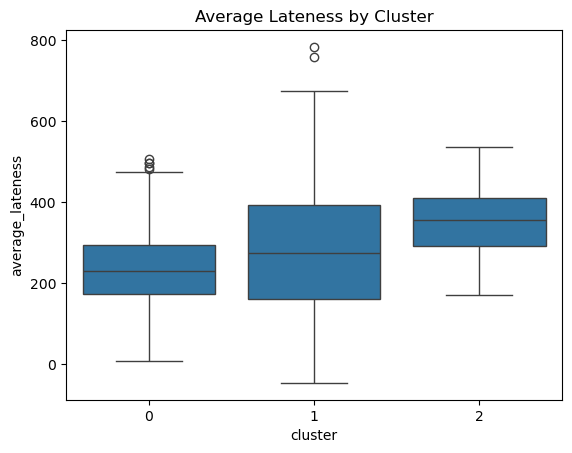

In [40]:
# Show average feature values per cluster
cluster_summary = pivot_df.groupby("cluster").mean()
display(cluster_summary)

# Visualize
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(data=pivot_df, x="cluster", y="average_lateness")
plt.title("Average Lateness by Cluster")
plt.show()

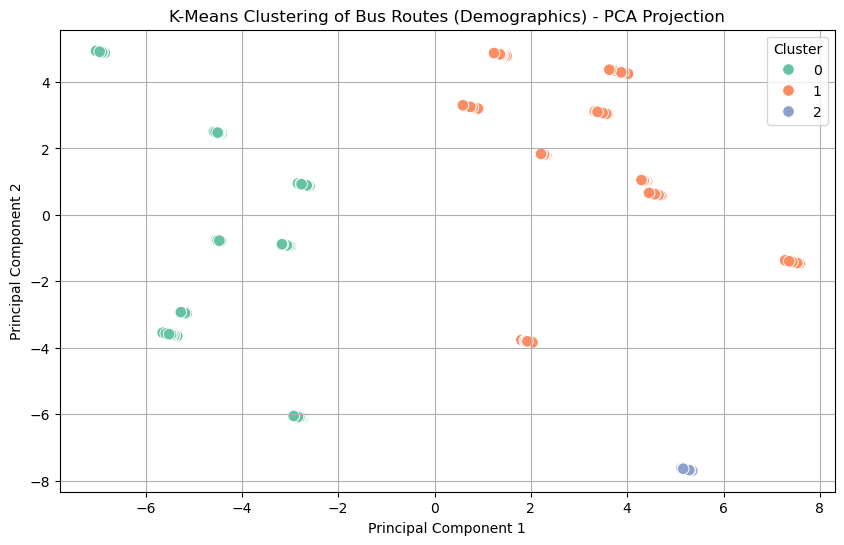

In [41]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Reduce to 2D using PCA
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_features)

# Create a DataFrame with 2D coordinates and cluster labels
visual_df = pd.DataFrame(reduced_features, columns=["PCA1", "PCA2"])
visual_df["Cluster"] = clusters

# Plot the clusters in 2D space
plt.figure(figsize=(10, 6))
sns.scatterplot(data=visual_df, x="PCA1", y="PCA2", hue="Cluster", palette="Set2", s=70)
plt.title("K-Means Clustering of Bus Routes (Demographics) - PCA Projection")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()


In [1]:
cluster_summary = pivot_df.groupby("cluster").mean()
display(cluster_summary)

NameError: name 'pivot_df' is not defined

In [ ]:
#pre covid lateness using the survey dataset 2015-2017 and the departure arrivals from 2018 (closest dataset)
precovid = "/Users/sarahyuhan/BostonBusEquity/2015-2017.xlsx"
df_pre = pd.read_excel(precovid)

df_pre = df_pre[df_pre['Mode'] == 'Bus']

# Convert route_id to match post-COVID dataset format
above_avg_routes_2018 = above_avg_routes_2018.copy()
above_avg_routes_2018["route_id"] = above_avg_routes_2018["route_id"].astype(str)

#df_post["reporting_group"] = df_post["reporting_group"].astype(str)

# Merge post-COVID data with routes that had above-average lateness
df_analysis2 = df_pre[df_pre["reporting_group"].isin(above_avg_routes_2018["route_id"])]

print("\nRoutes with Higher Than Average Lateness 2018:")
display(above_avg_routes_2018) 

In [ ]:
# Aggregate percentage data for routes with high lateness
#category_analysis = df_analysis2.groupby(["measure_group", "category"])["weighted_percent"].mean().reset_index()
#change this

# Sort to find the highest categories
category_analysis = category_analysis.sort_values(by="weighted_percent", ascending=False)